In [1]:
import os
import csv
import torch
from torch.utils.data import Dataset, ConcatDataset
import numpy as np
import pandas as pd

import h5py

In [2]:
with h5py.File("datasets/TCIR-CPAC_IO_SH.h5", "r") as f:
    info_group = f["info"]
    print("Keys in 'info' group:", list(info_group.keys()))
    

h5_path = "datasets/TCIR-CPAC_IO_SH.h5"

info_df = pd.read_hdf(h5_path, key='info')
print(info_df.head())

Keys in 'info' group: ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values']
  data_set       ID    lon   lat        time  Vmax  R35_4qAVG    MSLP
0     CPAC  200301C  223.5  12.5  2003081100  25.0        0.0  1009.0
1     CPAC  200301C  222.3  12.4  2003081103  25.0        0.0  1009.0
2     CPAC  200301C  221.2  12.4  2003081106  25.0        0.0  1009.0
3     CPAC  200301C  220.2  12.4  2003081109  25.0        0.0  1009.0
4     CPAC  200301C  219.2  12.3  2003081112  25.0        0.0  1009.0


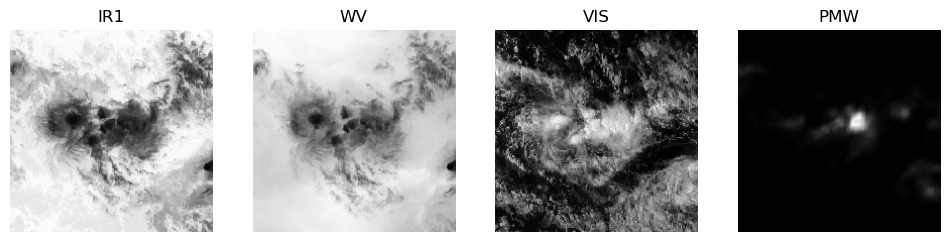

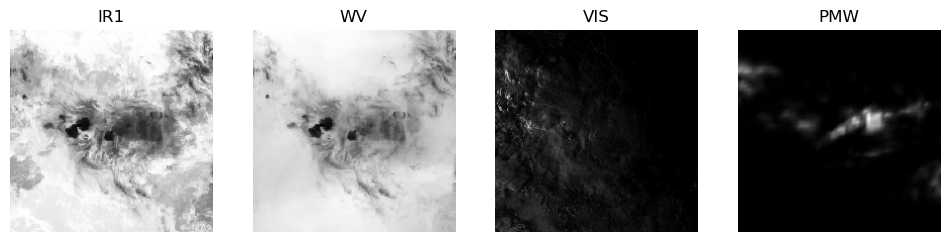

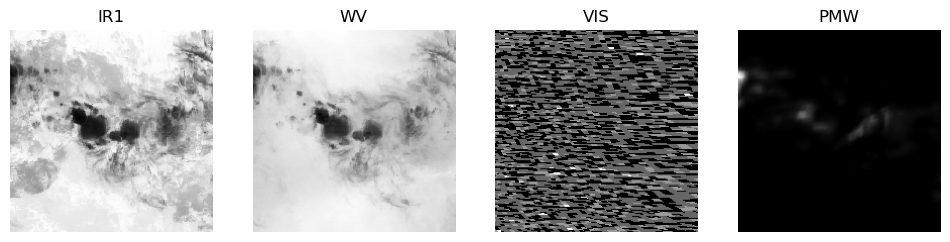

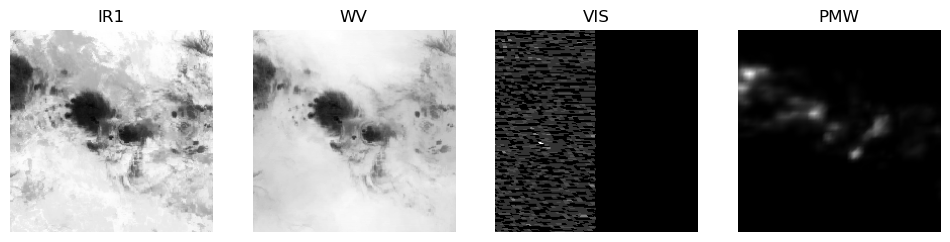

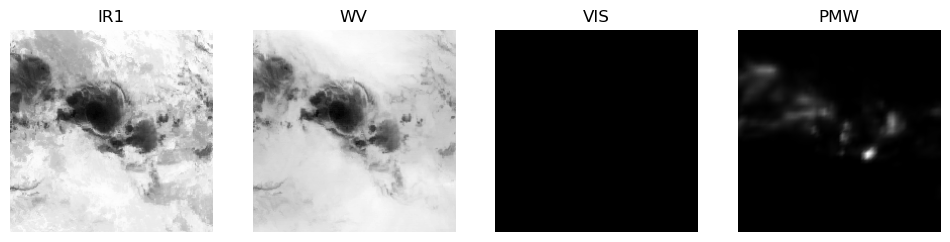

In [3]:
import matplotlib.pyplot as plt

h5_path = "datasets/TCIR-CPAC_IO_SH.h5"

with h5py.File(h5_path, 'r') as hf:
    data_matrix = hf['matrix'][:]  

# display first 5 images 
for i in range(5):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    channels = ['IR1', 'WV', 'VIS', 'PMW']
    
    for j in range(4):
        axs[j].imshow(data_matrix[i, :, :, j], cmap='gray')
        axs[j].set_title(channels[j])
        axs[j].axis('off')
    
    plt.show()


In [4]:
#create custom dataset with images and labels
class CustomImageDataset(Dataset):
    def __init__(self, path, transform=None, target="Vmax", baseline=False):
        self.h5_path = path
        self.transform = transform
        self.target = target
        self.baseline = baseline

        self.h5_file = h5py.File(self.h5_path, "r")
        #read images
        self.images = self.h5_file["matrix"]
        # read labels
        self.info_df = pd.read_hdf(self.h5_path, key="info")
        self.labels = self.info_df[self.target].values.astype(np.float32)

        assert len(self.images) == len(self.labels), "Match"

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # remove "visible" channel due to unreliability
        img_array = self.images[idx][:, :, [0, 1, 3]].astype(np.float32)

        # replace NaNs/Infs with 0
        img_array = np.nan_to_num(img_array, nan=0.0, posinf=0.0, neginf=0.0)

        # normalize to 0-1
        min_val = img_array.min()
        max_val = img_array.max()
        if max_val > min_val:
            img_array = (img_array - min_val) / (max_val - min_val)
        else:
            img_array = np.zeros_like(img_array, dtype=np.float32)

        img_tensor = torch.tensor(img_array).permute(2, 0, 1)
        
        mean = torch.tensor([0.5, 0.5, 0.5])
        std = torch.tensor([0.5, 0.5, 0.5])
        img_tensor = (img_tensor - mean[:, None, None]) / std[:, None, None]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        #use mean for linear regression case, to avoid overfitting
        if self.baseline:
            features = img_tensor.mean(dim=(1,2))
            return features, label
        else:
            return img_tensor, label


    def __del__(self):
        if hasattr(self, "h5_file"):
            self.h5_file.close()


In [5]:
# transform data
import torchvision.transforms as transforms

data_transformation = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),   
    transforms.Resize((224, 224)),               
    transforms.RandomHorizontalFlip(p=0.5),      
    transforms.RandomVerticalFlip(p=0.5),       
    transforms.RandomRotation(degrees=15),       
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# combine both datasets
data_folder_CPAC = "datasets/TCIR-CPAC_IO_SH.h5"
data_folder_ATLN = "datasets/TCIR-ATLN_EPAC_WPAC.h5"

data_CPAC = CustomImageDataset("datasets/TCIR-CPAC_IO_SH.h5", transform=data_transformation, target="Vmax")
data_ATLN = CustomImageDataset("datasets/TCIR-ATLN_EPAC_WPAC.h5", transform=data_transformation, target="Vmax")

combined_dataset = ConcatDataset([data_CPAC, data_ATLN])


# split data for training and testing
train_size = int(0.7 * len(combined_dataset))
test_size = len(combined_dataset) - train_size

train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

training_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)
testing_dataloader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)


In [7]:
#Vision Transformer model
import torchvision.models as models
import torch.nn as nn

resnet_18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

#use all 4 channels
#resnet_18.conv1 = nn.Conv2d(
#    in_channels=4,  
#    out_channels=resnet_18.conv1.out_channels,
#    kernel_size=resnet_18.conv1.kernel_size,
#    stride=resnet_18.conv1.stride,
#    padding=resnet_18.conv1.padding,
#    bias=resnet_18.conv1.bias is not None
#)

resnet_18.fc = nn.Linear(resnet_18.fc.in_features, 1) 


In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device}")

#send current model to GPU
model = resnet_18.to(device)

Using cuda


In [9]:
train_losses = []
val_losses = []

#training loop
def training_loop(dataloader, model, loss_function, optimizer, batch_size):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0.0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device).float().unsqueeze(1) 
        prediction = model(X)
        loss = loss_function(prediction, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X.size(0)
        
        if batch % 100 == 0:
            current = batch * batch_size + len(X)
            loss_text = f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]"
            print(loss_text)
            with open("Linear_log.txt", "a") as f:
                f.write(loss_text + "\n")
    epoch_loss = running_loss / size
    return epoch_loss

In [10]:
#testing loop
def test_loop(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    total_error = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).float().unsqueeze(1)
            prediction = model(X)
            total_error += torch.abs(prediction - y).sum().item()

    MAE = total_error / size
    MAE_text = "MAE: " + str(MAE)
    print(MAE_text)
    with open("Linear_log.txt", "a") as f:
        f.write(MAE_text + "\n")
        
    return MAE

In [11]:
#update parameters for training
from torch.optim.lr_scheduler import StepLR

learning_rate = .001
epochs = 20
current_model = resnet_18
single_loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(current_model.parameters(), lr = learning_rate, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

"""for t in range(epochs):
    epoch_label = (f"ResNet3: Epoch {t+1}\n-------------------------------")
    print(epoch_label)
    with open("ResNet3_log.txt", "a") as f:
        f.write(epoch_label + "\n")
    train_loss = training_loop(training_dataloader, current_model, single_loss_fn, optimizer, 16)
    val_loss = test_loop(testing_dataloader, current_model)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()
    
print("Done!")

plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss / MAE')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()"""


'for t in range(epochs):\n    epoch_label = (f"ResNet3: Epoch {t+1}\n-------------------------------")\n    print(epoch_label)\n    with open("ResNet3_log.txt", "a") as f:\n        f.write(epoch_label + "\n")\n    train_loss = training_loop(training_dataloader, current_model, single_loss_fn, optimizer, 16)\n    val_loss = test_loop(testing_dataloader, current_model)\n    \n    train_losses.append(train_loss)\n    val_losses.append(val_loss)\n    scheduler.step()\n    \nprint("Done!")\n\nplt.figure(figsize=(8,6))\nplt.plot(range(1, epochs+1), train_losses, label=\'Train Loss\')\nplt.plot(range(1, epochs+1), val_losses, label=\'Validation MAE\')\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'Loss / MAE\')\nplt.title(\'Training and Validation Loss\')\nplt.legend()\nplt.grid(True)\nplt.show()'

In [12]:
#Linear Regression Model for baseline comparison

class LinearRegressionModel(torch.nn.Module):

    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(3, 1)  

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred
    
data_CPAC_lin_reg = CustomImageDataset("datasets/TCIR-CPAC_IO_SH.h5", transform=data_transformation, target="Vmax", baseline=True)
data_ATLN_lin_reg = CustomImageDataset("datasets/TCIR-ATLN_EPAC_WPAC.h5", transform=data_transformation, target="Vmax",baseline=True)

combined_dataset_lin_reg = ConcatDataset([data_CPAC_lin_reg, data_ATLN_lin_reg])


# split data for training and testing
train_size = int(0.7 * len(combined_dataset_lin_reg))
test_size = len(combined_dataset_lin_reg) - train_size

train_dataset_lin_reg, test_dataset_lin_reg = random_split(combined_dataset_lin_reg, [train_size, test_size])

training_dataloader_lr = DataLoader(train_dataset_lin_reg, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)
testing_dataloader_lr  = DataLoader(test_dataset_lin_reg, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

Linear: Epoch 1
-------------------------------
loss: 45.158092  [   16/49349]
loss: 48.707310  [ 1616/49349]
loss: 45.657173  [ 3216/49349]
loss: 37.580643  [ 4816/49349]
loss: 51.531948  [ 6416/49349]
loss: 58.862877  [ 8016/49349]
loss: 41.725868  [ 9616/49349]
loss: 55.504246  [11216/49349]
loss: 36.650009  [12816/49349]
loss: 38.314789  [14416/49349]
loss: 39.227352  [16016/49349]
loss: 51.627930  [17616/49349]
loss: 64.410751  [19216/49349]
loss: 40.231125  [20816/49349]
loss: 47.358704  [22416/49349]
loss: 50.584671  [24016/49349]
loss: 66.244797  [25616/49349]
loss: 45.161942  [27216/49349]
loss: 36.129852  [28816/49349]
loss: 34.848061  [30416/49349]
loss: 32.939270  [32016/49349]
loss: 51.179550  [33616/49349]
loss: 37.491795  [35216/49349]
loss: 44.837433  [36816/49349]
loss: 40.018620  [38416/49349]
loss: 36.865501  [40016/49349]
loss: 26.998646  [41616/49349]
loss: 35.620010  [43216/49349]
loss: 34.504139  [44816/49349]
loss: 46.455673  [46416/49349]
loss: 41.423050  [4801

loss: 8.907220  [48016/49349]
MAE: 21.35900404152295
Linear: Epoch 9
-------------------------------
loss: 21.339945  [   16/49349]
loss: 19.748728  [ 1616/49349]
loss: 23.272158  [ 3216/49349]
loss: 20.971626  [ 4816/49349]
loss: 22.608227  [ 6416/49349]
loss: 17.891167  [ 8016/49349]
loss: 19.961407  [ 9616/49349]
loss: 16.581669  [11216/49349]
loss: 21.950809  [12816/49349]
loss: 18.960369  [14416/49349]
loss: 14.742275  [16016/49349]
loss: 9.391369  [17616/49349]
loss: 19.406752  [19216/49349]
loss: 22.390003  [20816/49349]
loss: 15.864546  [22416/49349]
loss: 27.409515  [24016/49349]
loss: 21.220810  [25616/49349]
loss: 17.606228  [27216/49349]
loss: 26.855280  [28816/49349]
loss: 24.989384  [30416/49349]
loss: 20.856144  [32016/49349]
loss: 23.557415  [33616/49349]
loss: 20.378971  [35216/49349]
loss: 25.829985  [36816/49349]
loss: 24.822563  [38416/49349]
loss: 18.605673  [40016/49349]
loss: 17.963280  [41616/49349]
loss: 11.570431  [43216/49349]
loss: 15.605300  [44816/49349]
l

loss: 17.246120  [44816/49349]
loss: 22.912687  [46416/49349]
loss: 20.030291  [48016/49349]
MAE: 21.340407886910945
Linear: Epoch 17
-------------------------------
loss: 20.554031  [   16/49349]
loss: 16.092813  [ 1616/49349]
loss: 19.381275  [ 3216/49349]
loss: 16.379456  [ 4816/49349]
loss: 15.484766  [ 6416/49349]
loss: 20.779327  [ 8016/49349]
loss: 19.437254  [ 9616/49349]
loss: 30.944613  [11216/49349]
loss: 25.676056  [12816/49349]
loss: 29.883661  [14416/49349]
loss: 27.432001  [16016/49349]
loss: 14.337584  [17616/49349]
loss: 22.162910  [19216/49349]
loss: 14.607788  [20816/49349]
loss: 29.956581  [22416/49349]
loss: 17.580797  [24016/49349]
loss: 21.263142  [25616/49349]
loss: 14.458258  [27216/49349]
loss: 26.069605  [28816/49349]
loss: 27.018513  [30416/49349]
loss: 18.770357  [32016/49349]
loss: 28.183926  [33616/49349]
loss: 22.884758  [35216/49349]
loss: 10.940021  [36816/49349]
loss: 18.735172  [38416/49349]
loss: 19.130968  [40016/49349]
loss: 19.180573  [41616/4934

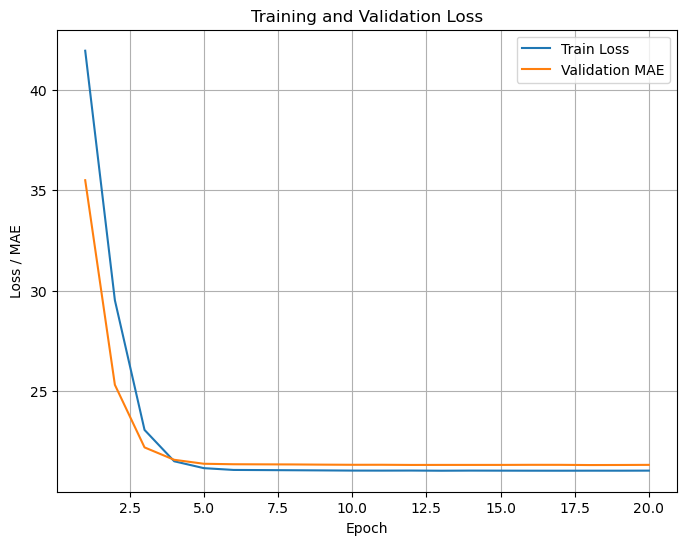

In [13]:

linear_model = LinearRegressionModel()
model_lin = linear_model.to(device)

learning_rate = .001
epochs = 20
current_model = linear_model
single_loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(current_model.parameters(), lr = learning_rate, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for t in range(epochs):
    epoch_label = (f"Linear: Epoch {t+1}\n-------------------------------")
    print(epoch_label)
    with open("Linear_log.txt", "a") as f:
        f.write(epoch_label + "\n")
    train_loss = training_loop(training_dataloader_lr, current_model, single_loss_fn, optimizer, 16)
    val_loss = test_loop(testing_dataloader_lr, current_model)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()
    
print("Done!")

plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss / MAE')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()